<a href="https://colab.research.google.com/github/prisha7/automatic-grading-of-student-answers/blob/main/Prisha_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q sentence-transformers torch scikit-learn pandas numpy nltk matplotlib seaborn

In [ ]:

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score

# Sentence Transformers (SBERT)
from sentence_transformers import SentenceTransformer
import torch
from torch.nn.functional import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: False


In [ ]:
#from google.colab import files
#print("Please upload your ASAP dataset file (ASAP2_train_sourcetexts.csv)...")
#uploaded = files.upload()
#filename = list(uploaded.keys())[0]

data = pd.read_csv('ASAP2_train_sourcetexts.csv')
print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {data.shape}")
print(f"\nColumn names:")
print(data.columns.tolist())

data = data[['essay_id', 'score', 'full_text', 'prompt_name']]

print(f"\nSelected columns: {data.columns.tolist()}")
print(f"\nFirst few rows:")
print(data.head())

print(f"\nScore distribution:")
print(data['score'].value_counts().sort_index())

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Remove rows with missing values
data = data.dropna()
print(f"\nDataset after removing missing values: {data.shape}")


Dataset loaded successfully!
Dataset shape: (24728, 14)

Column names:
['essay_id', 'score', 'full_text', 'assignment', 'prompt_name', 'economically_disadvantaged', 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender', 'source_text_1', 'source_text_2', 'source_text_3', 'source_text_4']

Selected columns: ['essay_id', 'score', 'full_text', 'prompt_name']

First few rows:
               essay_id  score  \
0  AAAVUP14319000159574      4   
1  AAAVUP14319000159542      2   
2  AAAVUP14319000159461      3   
3  AAAVUP14319000159420      2   
4  AAAVUP14319000159419      2   

                                           full_text      prompt_name  
0  The author suggests that studying Venus is wor...  Exploring Venus  
1  NASA is fighting to be alble to to go to Venus...  Exploring Venus  
2  "The Evening Star", is one of the brightest po...  Exploring Venus  
3  The author supports this idea because from rea...  Exploring Venus  
4  How the author supports this idea is that

In [ ]:
# CELL 4: Text Preprocessing Functions
def clean_text(text):
      """Clean and normalize text"""
      text = text.lower()
      text = re.sub(r'[^a-z\s]', '', text)            # Remove non-alphabetic characters
      text = re.sub(r'\s+', ' ', text).strip()        # Normalize whitespace
      return text

print("Applying text cleaning...")
data['clean_essay'] = data['full_text'].apply(clean_text)
data['clean_prompt'] = data['prompt_name'].apply(clean_text)

print(" Text cleaning complete!")
print(f"\nOriginal essay example:")
print(data['full_text'].iloc[0][:200])
print(f"\nCleaned essay example:")
print(data['clean_essay'].iloc[0][:200])

Applying text cleaning...
 Text cleaning complete!

Original essay example:
The author suggests that studying Venus is worthy enough even though it is very dangerous. The author mentioned that on the planet's surface, temperatures average over 800 degrees Fahrenheit, and the 

Cleaned essay example:
the author suggests that studying venus is worthy enough even though it is very dangerous the author mentioned that on the planets surface temperatures average over degrees fahrenheit and the atmosphe


In [ ]:
#Cell 5 : Tokenization
print("Tokenizing text...")
# Download the missing resource
nltk.download('punkt_tab')
data['tokens'] = data['clean_essay'].apply(word_tokenize)
data['tokens_prompt_name'] = data['clean_prompt'].apply(word_tokenize)

print("Tokenization complete!")
print(f"\nExample tokens (first 20):")
print(data['tokens'].iloc[0][:20])

Tokenizing text...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenization complete!

Example tokens (first 20):
['the', 'author', 'suggests', 'that', 'studying', 'venus', 'is', 'worthy', 'enough', 'even', 'though', 'it', 'is', 'very', 'dangerous', 'the', 'author', 'mentioned', 'that', 'on']


In [ ]:
#Cell 6:Remove stop words

stop_words = set(stopwords.words('english'))

print("Removing stop words...")
data['filtered_tokens'] = data['tokens'].apply(
    lambda tokens: [t for t in tokens if t not in stop_words]
    )

data['filtered_tokens_prompt_name'] = data['tokens_prompt_name'].apply(
      lambda tokens: [t for t in tokens if t not in stop_words]
      )

print("Stop words removed!")
print(f"\nTokens before: {len(data['tokens'].iloc[0])}")
print(f"Tokens after: {len(data['filtered_tokens'].iloc[0])}")









Removing stop words...
Stop words removed!

Tokens before: 389
Tokens after: 209


In [ ]:
#Cell 7 : Stemming

stemmer = PorterStemmer()

print("Applying stemming...")
data['stemmed_tokens'] = data['filtered_tokens'].apply(
    lambda tokens: [stemmer.stem(t) for t in tokens]
    )

data['stemmed_text'] = data['stemmed_tokens'].apply(
      lambda tokens: ' '.join(tokens)
      )
data['stemmed_tokens_prompt_name'] = data['filtered_tokens_prompt_name'].apply(
      lambda tokens: [stemmer.stem(t) for t in tokens]
      )
data['stemmed_prompt'] = data['stemmed_tokens_prompt_name'].apply(
      lambda tokens: ' '.join(tokens)
      )
print("Stemming complete!")
print(f"\nOriginal tokens: {data['filtered_tokens'].iloc[0][:10]}")
print(f"Stemmed tokens: {data['stemmed_tokens'].iloc[0][:10]}")


Applying stemming...
Stemming complete!

Original tokens: ['author', 'suggests', 'studying', 'venus', 'worthy', 'enough', 'even', 'though', 'dangerous', 'author']
Stemmed tokens: ['author', 'suggest', 'studi', 'venu', 'worthi', 'enough', 'even', 'though', 'danger', 'author']


In [ ]:
# CELL 8: TF-IDF Vectorization (Keyword Similarity)
# ============================================================================

print("Computing TF-IDF vectors and keyword similarity...")

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
essay_vecs = tfidf.fit_transform(data['stemmed_text'])
prompt_vecs = tfidf.transform(data['stemmed_prompt'])

# Compute cosine similarity for each pair (element-wise)
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine

keyword_sim = [
    sklearn_cosine(prompt_vecs[i], essay_vecs[i])[0, 0]
        for i in range(len(data))
        ]

data['keyword_similarity'] = keyword_sim

print("✓ Keyword similarity computed!")
print(f"\nKeyword similarity statistics:")
print(data['keyword_similarity'].describe())

        # Save TF-IDF essay features
essay_tfidf_features = essay_vecs.toarray()
print(f"\nTF-IDF feature matrix shape: {essay_tfidf_features.shape}")

Computing TF-IDF vectors and keyword similarity...
✓ Keyword similarity computed!

Keyword similarity statistics:
count    24728.000000
mean         0.287371
std          0.185653
min          0.000000
25%          0.123834
50%          0.291679
75%          0.428287
max          0.833706
Name: keyword_similarity, dtype: float64

TF-IDF feature matrix shape: (24728, 5000)


In [ ]:
# CELL 9: SBERT Vectorization (Semantic Similarity)
# ============================================================================

print("Loading SBERT model and computing semantic similarity...")

# Load SBERT model (lightweight, works well on CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sbert = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"✓ SBERT model loaded on {device}")

# Encode text
print("Encoding prompts...")
prompt_vecs = sbert.encode(data['clean_prompt'].tolist(), convert_to_tensor=True, show_progress_bar=True)

print("Encoding essays...")
essay_vecs = sbert.encode(data['clean_essay'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# Compute cosine similarity for each row
print("Computing semantic similarity...")
semantic_sim = cosine_similarity(prompt_vecs, essay_vecs).cpu().numpy()
data['semantic_similarity'] = semantic_sim

print("Semantic similarity computed!")
print(f"\nSemantic similarity statistics:")
print(data['semantic_similarity'].describe())

# Save SBERT embeddings for later use
essay_sbert_features = essay_vecs.cpu().numpy()
print(f"\nSBERT embedding shape: {essay_sbert_features.shape}")

Loading SBERT model and computing semantic similarity...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ SBERT model loaded on cpu
Encoding prompts...


Batches:   0%|          | 0/773 [00:00<?, ?it/s]

Encoding essays...


Batches:   0%|          | 0/773 [00:00<?, ?it/s]

Computing semantic similarity...
Semantic similarity computed!

Semantic similarity statistics:
count    24728.000000
mean         0.530395
std          0.143791
min         -0.074128
25%          0.441605
50%          0.572687
75%          0.639474
max          0.792760
Name: semantic_similarity, dtype: float64

SBERT embedding shape: (24728, 384)


In [ ]:
# CELL 10: Extract Additional Features
# ============================================================================

print("Extracting additional features...")

# Basic text features
data['essay_length'] = data['full_text'].apply(len)
data['word_count'] = data['tokens'].apply(len)
data['unique_word_count'] = data['tokens'].apply(lambda x: len(set(x)))
data['avg_word_length'] = data['tokens'].apply(
    lambda x: np.mean([len(word) for word in x]) if len(x) > 0 else 0
    )
data['sentence_count'] = data['full_text'].apply(lambda x: len(re.split(r'[.!?]+', x)))

# Vocabulary richness
data['lexical_diversity'] = data['unique_word_count'] / data['word_count']

# Prompt-related features
data['prompt_word_overlap'] = data.apply(
    lambda row: len(set(row['tokens']) & set(row['tokens_prompt_name'])) / len(set(row['tokens_prompt_name']))
        if len(row['tokens_prompt_name']) > 0 else 0,
            axis=1
            )

print("Additional features extracted")

# Display all feature columns
feature_cols = ['keyword_similarity', 'semantic_similarity', 'essay_length',
                'word_count', 'unique_word_count', 'avg_word_length',
                'sentence_count', 'lexical_diversity', 'prompt_word_overlap'
                ]

print(f"\nFeature summary:")
print(data[feature_cols].describe())

Extracting additional features...
Additional features extracted

Feature summary:
       keyword_similarity  semantic_similarity  essay_length    word_count  \
count        24728.000000         24728.000000  24728.000000  24728.000000   
mean             0.287371             0.530395   2035.659253    360.142470   
std              0.185653             0.143791    900.741881    147.576402   
min              0.000000            -0.074128    697.000000    150.000000   
25%              0.123834             0.441605   1376.000000    247.000000   
50%              0.291679             0.572687   1881.000000    336.000000   
75%              0.428287             0.639474   2501.000000    442.000000   
max              0.833706             0.792760  20459.000000   1656.000000   

       unique_word_count  avg_word_length  sentence_count  lexical_diversity  \
count       24728.000000     24728.000000    24728.000000       24728.000000   
mean          164.956082         4.439866       20.5466

In [ ]:
# CELL 11: Prepare Feature Matrix
# ============================================================================

print("Preparing feature matrix...")

# Combine all features
basic_features = data[['keyword_similarity', 'semantic_similarity', 'essay_length',
                        'word_count', 'unique_word_count', 'avg_word_length',
                        'sentence_count', 'lexical_diversity', 'prompt_word_overlap']].values

# Option 1: Use only basic features + similarity scores
X_basic = basic_features

X = X_basic
y = data['score'].values

print(f"Feature matrix prepared!")
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Preparing feature matrix...
Feature matrix prepared!
Feature matrix shape: (24728, 9)
Target shape: (24728,)


In [ ]:
# CELL 12: Split Data and Scale Features
# ============================================================================

print("Splitting data into train and test sets...")

# Split data (80-20 train-test split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation complete!")

# Check score distribution
print(f"\nTrain score distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest score distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Splitting data into train and test sets...
Training samples: 19782
Testing samples: 4946

Scaling features...
Data preparation complete!

Train score distribution:
1    1401
2    5477
3    7217
4    4442
5    1085
6     160
Name: count, dtype: int64

Test score distribution:
1     350
2    1370
3    1804
4    1111
5     271
6      40
Name: count, dtype: int64


In [ ]:
# CELL 13: Train Multiple Regression Models
# ============================================================================

print("="*80)
print("TRAINING REGRESSION MODELS")
print("="*80)


models = {
      'Linear Regression': LinearRegression(),
      'Ridge Regression': Ridge(alpha=10.0),
      'Lasso Regression': Lasso(alpha=1.0),
      'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
      'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
      'Support Vector Regression': SVR(kernel='rbf', C=10.0)
       }

# Train models
trained_models = {}
predictions_dict = {}


for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions_dict[name] = y_pred

    print(f"{name} trained successfully!")


print("\n" + "="*80)
print("All models trained!")
print("="*80)

TRAINING REGRESSION MODELS

Training Linear Regression...
Linear Regression trained successfully!

Training Ridge Regression...
Ridge Regression trained successfully!

Training Lasso Regression...
Lasso Regression trained successfully!

Training Random Forest...
Random Forest trained successfully!

Training Gradient Boosting...
Gradient Boosting trained successfully!

Training Support Vector Regression...
Support Vector Regression trained successfully!

All models trained!


In [ ]:
# CELL 14: Evaluate Models
# ============================================================================

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model with multiple metrics"""
    # Get score range
    min_score = y_true.min()
    max_score = y_true.max()

    # Round predictions to nearest valid score
    y_pred_rounded = np.clip(np.round(y_pred), min_score, max_score)


    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred_rounded, weights='quadratic')

    # Accuracy within 1 point
    within_one = np.mean(np.abs(y_true - y_pred_rounded) <= 1)

    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'QWK': qwk,
        'Within 1 Point': within_one
        }
# Evaluate all models
results = []

print("="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)

for name, y_pred in predictions_dict.items():
    metrics = evaluate_model(y_test, y_pred, name)
    results.append(metrics)
    print(f"\n{name}:")
    print(f"  MSE:  {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  MAE:  {metrics['MAE']:.4f}")
    print(f"  R²:   {metrics['R²']:.4f}")
    print(f"  Quadratic Weighted Kappa: {metrics['QWK']:.4f}")
    print(f"  Accuracy within 1 point: {metrics['Within 1 Point']:.2%}")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('QWK', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY (Sorted by QWK)")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_qwk = results_df.iloc[0]['QWK']

print("\n" + "="*80)
print(f" BEST MODEL: {best_model_name}")
print(f"   Quadratic Weighted Kappa: {best_qwk:.4f}")
print("="*80)

MODEL EVALUATION RESULTS

Linear Regression:
  MSE:  0.4758
  RMSE: 0.6898
  MAE:  0.5262
  R²:   0.5566
  Quadratic Weighted Kappa: 0.6849
  Accuracy within 1 point: 96.62%

Ridge Regression:
  MSE:  0.4757
  RMSE: 0.6897
  MAE:  0.5262
  R²:   0.5566
  Quadratic Weighted Kappa: 0.6851
  Accuracy within 1 point: 96.62%

Lasso Regression:
  MSE:  1.0730
  RMSE: 1.0359
  MAE:  0.7953
  R²:   -0.0000
  Quadratic Weighted Kappa: 0.0000
  Accuracy within 1 point: 86.64%

Random Forest:
  MSE:  0.4464
  RMSE: 0.6681
  MAE:  0.5079
  R²:   0.5840
  Quadratic Weighted Kappa: 0.7078
  Accuracy within 1 point: 96.77%

Gradient Boosting:
  MSE:  0.4327
  RMSE: 0.6578
  MAE:  0.5028
  R²:   0.5968
  Quadratic Weighted Kappa: 0.7117
  Accuracy within 1 point: 96.91%

Support Vector Regression:
  MSE:  0.4354
  RMSE: 0.6598
  MAE:  0.4841
  R²:   0.5943
  Quadratic Weighted Kappa: 0.7119
  Accuracy within 1 point: 96.97%

RESULTS SUMMARY (Sorted by QWK)
                    Model      MSE     RMSE  

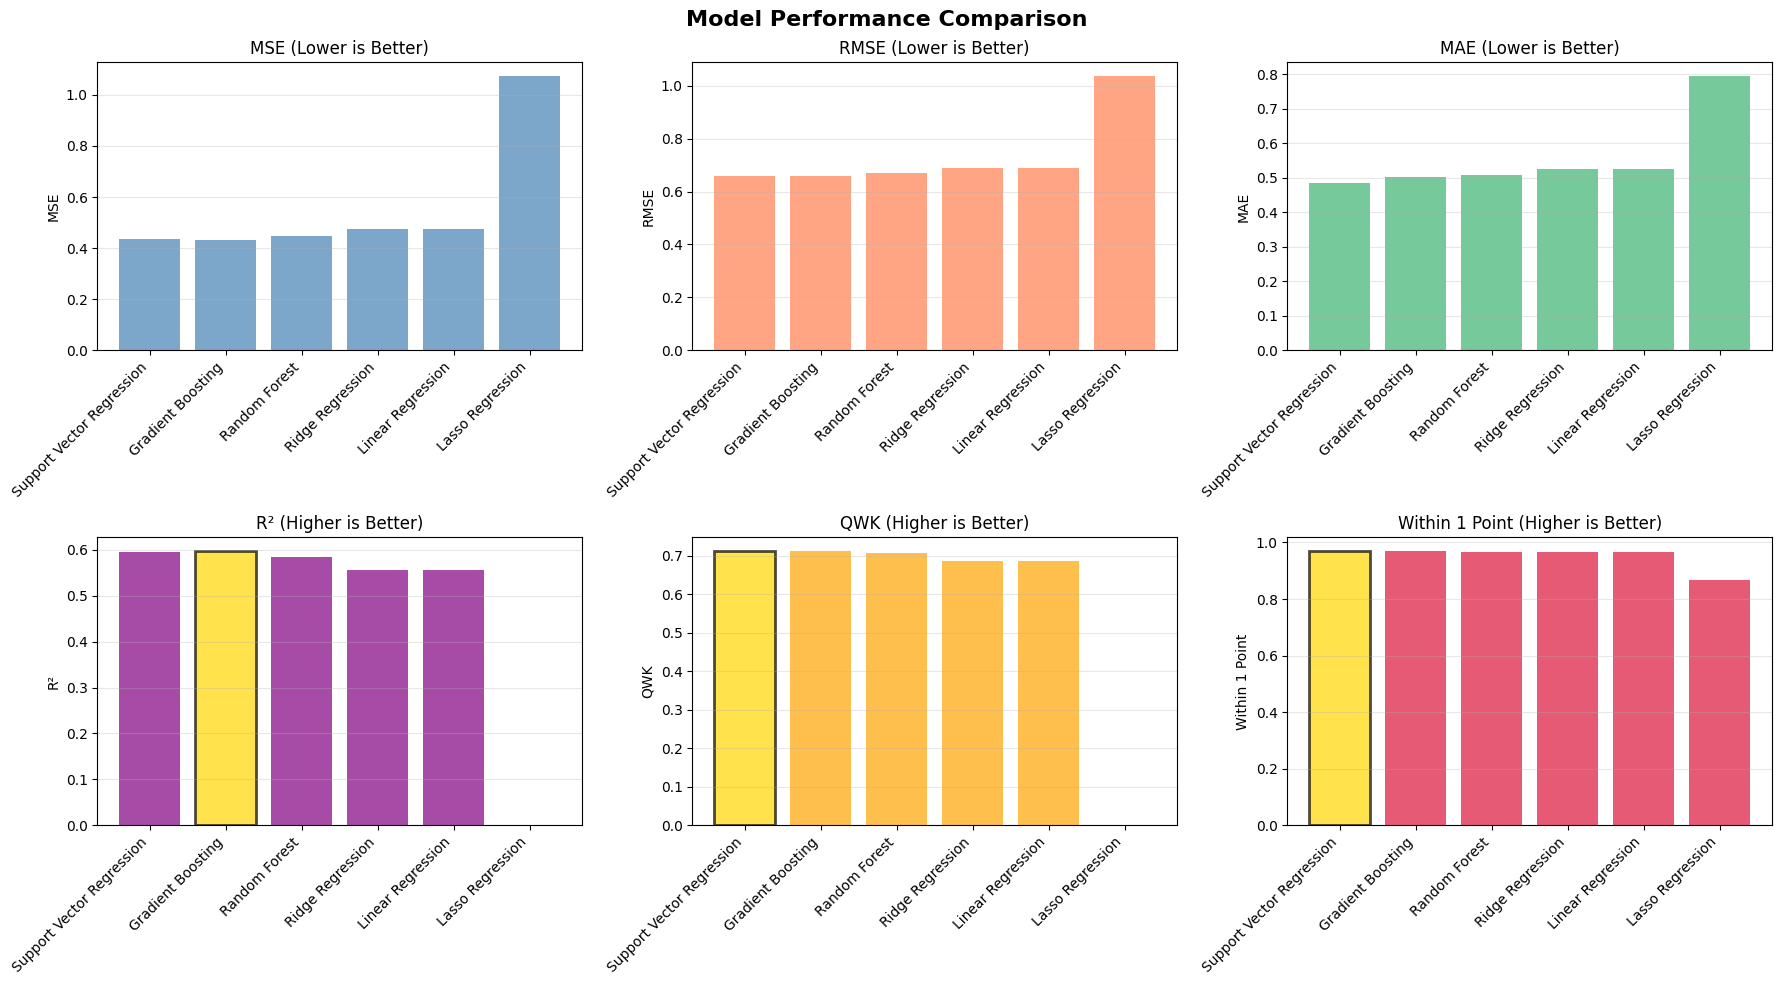

In [ ]:
# CELL 15: Visualize Model Comparison
# ============================================================================

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Prepare data for plotting
model_names = results_df['Model'].tolist()
metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R²', 'QWK', 'Within 1 Point']
colors = ['steelblue', 'coral', 'mediumseagreen', 'purple', 'orange', 'crimson']


for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    values = results_df[metric].tolist()

    bars = ax.bar(range(len(model_names)), values, color=color, alpha=0.7)
    ax.set_title(f'{metric} {"(Lower is Better)" if metric in ["MSE", "RMSE", "MAE"] else "(Higher is Better)"}')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    if metric in ['MSE', 'RMSE', 'MAE']:
        best_idx = values.index(min(values))
    else:
        best_idx = values.index(max(values))
        bars[best_idx].set_color('gold')
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(2)
plt.tight_layout()
plt.show()

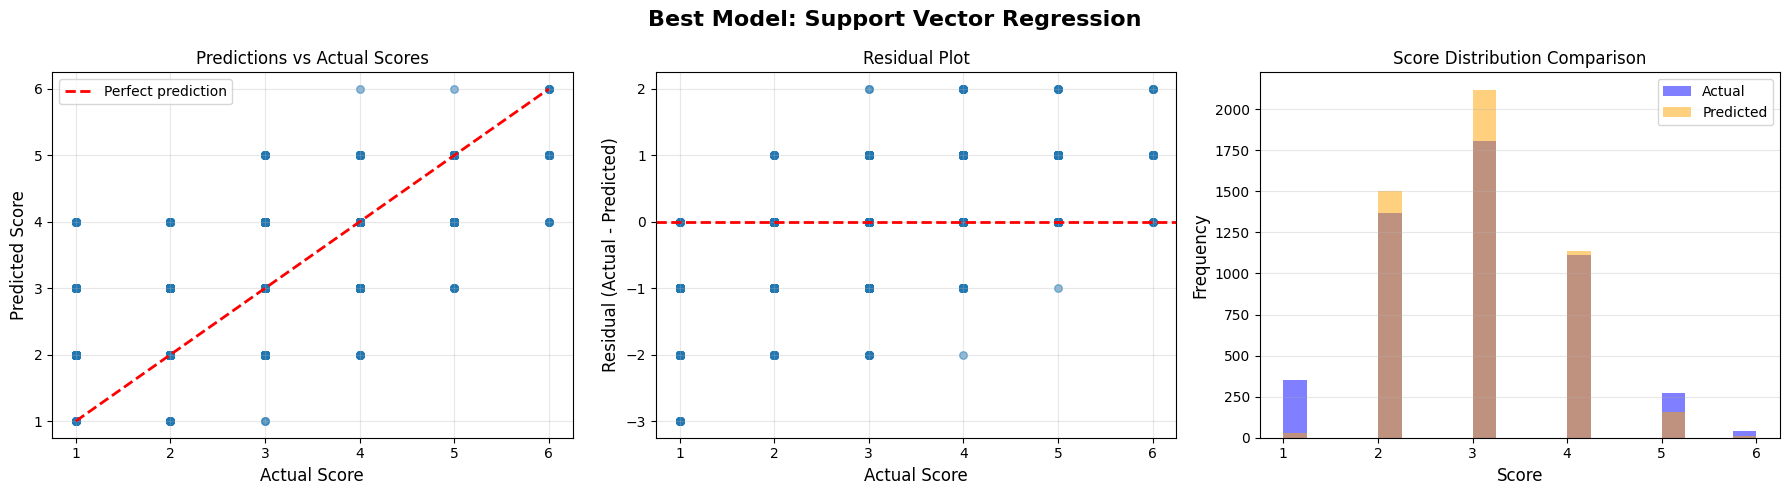

In [ ]:
# CELL 16: Prediction vs Actual Visualization
# ============================================================================

# Get predictions from best model
best_model = trained_models[best_model_name]
y_pred_best = predictions_dict[best_model_name]

min_score = y_test.min()
max_score = y_test.max()
y_pred_rounded = np.clip(np.round(y_pred_best), min_score, max_score)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Best Model: {best_model_name}', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot of predictions vs actual
axes[0].scatter(y_test, y_pred_rounded, alpha=0.5, s=30)
axes[0].plot([min_score, max_score], [min_score, max_score], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Score', fontsize=12)
axes[0].set_ylabel('Predicted Score', fontsize=12)
axes[0].set_title('Predictions vs Actual Scores')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Residual plot
residuals = y_test - y_pred_rounded
axes[1].scatter(y_test, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Actual Score', fontsize=12)
axes[1].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

# Plot 3: Distribution comparison
axes[2].hist(y_test, bins=20, alpha=0.5, label='Actual', color='blue')
axes[2].hist(y_pred_rounded, bins=20, alpha=0.5, label='Predicted', color='orange')
axes[2].set_xlabel('Score', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Score Distribution Comparison')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

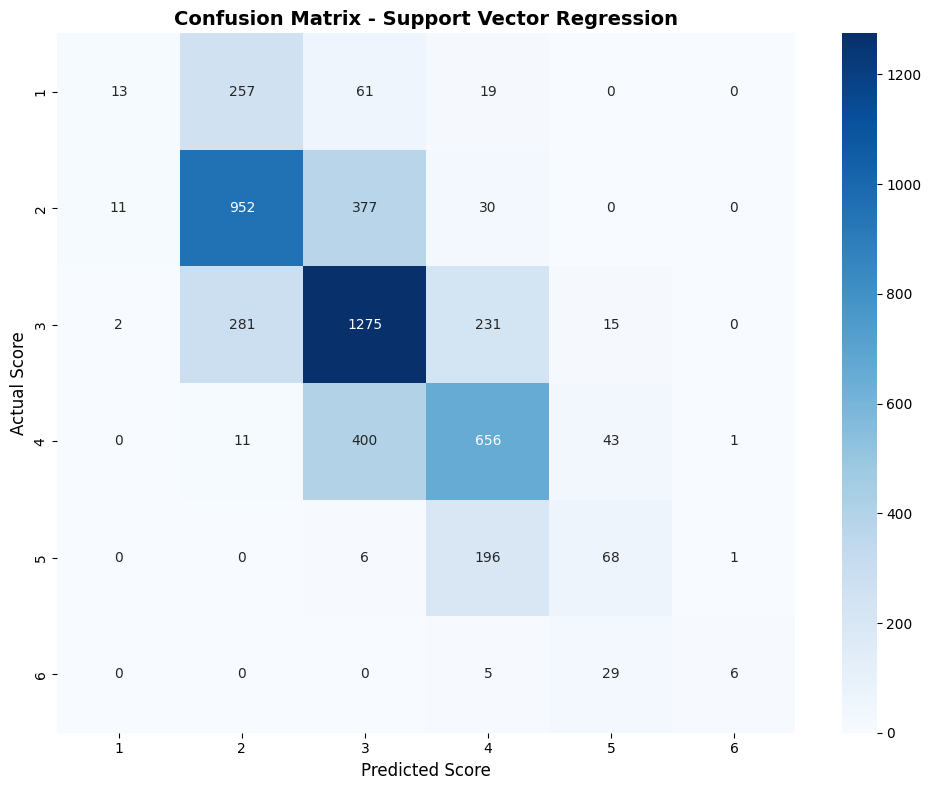

ACCURACY PER SCORE LEVEL
Score 1: 3.71% (350 samples)
Score 2: 69.49% (1370 samples)
Score 3: 70.68% (1804 samples)
Score 4: 59.05% (1111 samples)
Score 5: 25.09% (271 samples)
Score 6: 15.00% (40 samples)


In [ ]:
# CELL 17: Confusion Matrix for Best Model
# ============================================================================

from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_test)),
            yticklabels=sorted(np.unique(y_test)))
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Actual Score', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate accuracy per score
print("="*80)
print("ACCURACY PER SCORE LEVEL")
print("="*80)

for score in sorted(np.unique(y_test)):
    mask = y_test == score
    accuracy = np.mean(y_pred_rounded[mask] == score)
    print(f"Score {score}: {accuracy:.2%} ({mask.sum()} samples)")

In [ ]:
# CELL 18: Feature Importance Analysis
# ============================================================================

# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = best_model.feature_importances_

    feature_names = ['keyword_similarity', 'semantic_similarity', 'essay_length',
    'word_count', 'unique_word_count', 'avg_word_length',
    'sentence_count', 'lexical_diversity', 'prompt_word_overlap']

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance }).sort_values('Importance', ascending=False)

    print("="*80)
    print(f"FEATURE IMPORTANCE ({best_model_name})")
    print("="*80)
    print(importance_df.to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['Importance'], color='skyblue')
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# CELL 19: Sample Predictions Analysis
# ============================================================================

# Create detailed results dataframe
indices = list(range(len(y_test)))
test_results = pd.DataFrame({
    'actual_score': y_test,
    'predicted_score': y_pred_rounded,
    'raw_prediction': y_pred_best,
    'difference': np.abs(y_test - y_pred_rounded)
    })

# Get test indices
test_indices = X_test_scaled.shape[0]
original_test_indices = data.index[-test_indices:]

# Show 10 random samples
num_samples = min(10, len(test_results))
sample_indices = np.random.choice(len(test_results), size=num_samples, replace=False)

for i, idx in enumerate(sample_indices, 1):
    orig_idx = original_test_indices[idx]
    row = test_results.iloc[idx]

    print(f"\n{'─'*80}")
    print(f"Sample {i}:")
    print(f"{'─'*80}")

    essay_preview = data.loc[orig_idx, 'full_text'][:300]
    if len(data.loc[orig_idx, 'full_text']) > 300:
        essay_preview += "..."

    print(f"Essay Preview: {essay_preview}")
    print(f"\nActual Score:    {row['actual_score']}")
    print(f"Predicted Score: {row['predicted_score']}")
    print(f"Raw Prediction:  {row['raw_prediction']:.2f}")
    print(f"Difference:      {row['difference']}")

    if row['difference'] == 0:
        print("Perfect match!")
    elif row['difference'] <= 1:
        print("Close prediction")
    else:
        print("Significant difference")


# Overall statistics
print(f"\n{'='*80}")
print("OVERALL PREDICTION STATISTICS")
print(f"{'='*80}")
exact_matches = (test_results['difference'] == 0).sum()
within_one = (test_results['difference'] <= 1).sum()
within_two = (test_results['difference'] <= 2).sum()

print(f"Exact matches:     {exact_matches}/{len(test_results)} ({exact_matches/len(test_results)*100:.1f}%)")
print(f"Within 1 point:    {within_one}/{len(test_results)} ({within_one/len(test_results)*100:.1f}%)")
print(f"Within 2 points:   {within_two}/{len(test_results)} ({within_two/len(test_results)*100:.1f}%)")


────────────────────────────────────────────────────────────────────────────────
Sample 1:
────────────────────────────────────────────────────────────────────────────────
Essay Preview: Dear senator,

Imagine it being the year for choosing for a new president for the United States of America. You cast your vote, for which president you thought that would be best to run our country. After, you hear the results you become very disappointed , Because the presdient won not by the popul...

Actual Score:    2.0
Predicted Score: 3.0
Raw Prediction:  3.15
Difference:      1.0
Close prediction

────────────────────────────────────────────────────────────────────────────────
Sample 2:
────────────────────────────────────────────────────────────────────────────────
Essay Preview: cars all around the world are a big part of many peoples daily use. they are used so much that it is starting to become a big problem in major cities like paris, beijing, and new york. now these cities and governments

In [ ]:
# CELL 20: Function to Grade New Essays
# ============================================================================

def grade_new_essay(essay_text, prompt_text, model_package):
    """
    Grade a new essay using the trained model

    Args:
        essay_text: The student's essay
        prompt_text: The prompt/question
        model_package: Dictionary containing model and preprocessing tools

    Returns:
        Predicted score and detailed analysis
    """

    # Extract tools from package
    model = model_package['model']
    scaler = model_package['scaler']
    sbert_model = model_package['sbert_model']
    tfidf_vec = model_package['tfidf_vectorizer']

    # Clean text
    clean_essay = clean_text(essay_text)
    clean_prompt = clean_text(prompt_text)

    # Tokenize
    tokens_essay = word_tokenize(clean_essay)
    tokens_prompt = word_tokenize(clean_prompt)

    # Remove stopwords and stem
    filtered_essay = [t for t in tokens_essay if t not in stop_words]
    filtered_prompt = [t for t in tokens_prompt if t not in stop_words]

    stemmed_essay = [stemmer.stem(t) for t in filtered_essay]
    stemmed_prompt = [stemmer.stem(t) for t in filtered_prompt]

    stemmed_essay_text = ' '.join(stemmed_essay)
    stemmed_prompt_text = ' '.join(stemmed_prompt)

    # Compute keyword similarity (TF-IDF) - using correct method
    essay_vec = tfidf_vec.transform([stemmed_essay_text])
    prompt_vec = tfidf_vec.transform([stemmed_prompt_text])
    keyword_sim = sklearn_cosine(prompt_vec, essay_vec)[0, 0]

    # Compute semantic similarity (SBERT)
    prompt_vec_sbert = sbert_model.encode([clean_prompt], convert_to_tensor=True)
    essay_vec_sbert = sbert_model.encode([clean_essay], convert_to_tensor=True)
    semantic_sim = cosine_similarity(prompt_vec_sbert, essay_vec_sbert).cpu().numpy()[0]

    # Extract basic features
    essay_length = len(essay_text)
    word_count = len(tokens_essay)
    unique_word_count = len(set(tokens_essay))
    avg_word_length = np.mean([len(word) for word in tokens_essay]) if tokens_essay else 0
    sentence_count = len(re.split(r'[.!?]+', essay_text))
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    prompt_word_overlap = len(set(tokens_essay) & set(tokens_prompt)) / len(set(tokens_prompt)) if tokens_prompt else 0


    # Combine all features
    features = np.array([[
    keyword_sim,
    semantic_sim,
    essay_length,
    word_count,
    unique_word_count,
    avg_word_length,
    sentence_count,
    lexical_diversity,
                                                                                    prompt_word_overlap
                                                                                    ]])

    # Scale features
    features_scaled = scaler.transform(features)

    #Predict score
    raw_prediction = model.predict(features_scaled)[0]
    predicted_score = np.round(raw_prediction)

    # Create analysis report
    analysis = {
    'predicted_score': int(predicted_score),
    'raw_prediction': float(raw_prediction),
    'keyword_similarity': float(keyword_sim),
    'semantic_similarity': float(semantic_sim),
    'essay_length': int(essay_length),
    'word_count': int(word_count),
    'unique_word_count': int(unique_word_count),
    'lexical_diversity': float(lexical_diversity),
                                                                                    'sentence_count': int(sentence_count)
                                                                                    }
    return predicted_score, analysis

# Test the function with a sample essay
print("="*80)
print("TESTING GRADING FUNCTION WITH NEW ESSAY")
print("="*80)

# Sample test essay
test_essay = """
Photosynthesis is a vital process for life on Earth. Plants use sunlight, water,
and carbon dioxide to produce glucose and oxygen. The chlorophyll in plant leaves
absorbs light energy, which drives the chemical reactions. This process not only
provides food for plants but also produces oxygen that animals need to breathe.
"""

test_prompt = "Explain the process of photosynthesis and its importance."


try:
    predicted_score, analysis = grade_new_essay(test_essay, test_prompt, model_package)

    print(f"\nTest Essay:")
    print(test_essay)
    print(f"\nPrompt:")
    print(test_prompt)
    print(f"\n{'─'*80}")
    print("GRADING RESULTS:")
    print(f"{'─'*80}")
    print(f"Predicted Score: {predicted_score}")
    print(f"Raw Prediction: {analysis['raw_prediction']:.2f}")
    print(f"\nFeature Analysis:")
    print(f"  Keyword Similarity: {analysis['keyword_similarity']:.3f}")
    print(f"  Semantic Similarity: {analysis['semantic_similarity']:.3f}")
    print(f"  Word Count: {analysis['word_count']}")
    print(f"  Unique Words: {analysis['unique_word_count']}")
    print(f"  Lexical Diversity: {analysis['lexical_diversity']:.3f}")
    print(f"  Sentence Count: {analysis['sentence_count']}")
    print(f"  Essay Length: {analysis['essay_length']} characters")

except Exception as e:
    print(f"Error during testing: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("ALL DONE!!!!")
print("="*80)
print("\nYou can now use the grade_new_essay() function to grade any new essay!")
print("The trained model has been saved and can be loaded for future use.")




TESTING GRADING FUNCTION WITH NEW ESSAY

Test Essay:

Photosynthesis is a vital process for life on Earth. Plants use sunlight, water, 
and carbon dioxide to produce glucose and oxygen. The chlorophyll in plant leaves 
absorbs light energy, which drives the chemical reactions. This process not only 
provides food for plants but also produces oxygen that animals need to breathe.


Prompt:
Explain the process of photosynthesis and its importance.

────────────────────────────────────────────────────────────────────────────────
GRADING RESULTS:
────────────────────────────────────────────────────────────────────────────────
Predicted Score: 1.0
Raw Prediction: 0.65

Feature Analysis:
  Keyword Similarity: 0.155
  Semantic Similarity: 0.794
  Word Count: 51
  Unique Words: 44
  Lexical Diversity: 0.863
  Sentence Count: 5
  Essay Length: 328 characters

ALL DONE!!!!

You can now use the grade_new_essay() function to grade any new essay!
The trained model has been saved and can be loaded fo